# Data Description #

## Players.csv ##
Contains player-level information - 196 unique players (observations) and 7 variables.

| Variable Name | type | missing values | meaning |
| :- | :- | :-: | :- |
|experience |character | 0 | Player's self-reported or assinged experience level (beginner, amateur, regular, pro or veteran).|
|subscribe |logical | 0 | Whether player has subscribed to the game-related newsletter (true/false).|
|hashedEmail |character | 0 | Player's email hashed as distinct values.|
|played_hours |double | 0 | Total hours a player has played.|
|name |character | 0 |Player's display name.|
|gender |character | 0 |Self registered gender of a player.|
|Age |double | 2 |Age in years.|


#### Summarised Statistics ####

Number of different types of player's experience
| Experience | Count |
| :- | :- |
|Amateur |63|
|Beginner |35|
|Pro |14|
|Regular|36|
|Veteran|8|

Subscriber count

| Subscriber | Count |
| :- | :- |
|TRUE| 52|
|FALSE| 144|

Hours played statistics
| count | mean| minimum | median | max |
| :- | :- | :- | :- | :- |
|196.00|5.85|0.00|0.10|223.10|

Age statistics
| count | mean| minimum | median | max |
|:-| :- | :- | :- | :- |
|196.00|21.14|9.00|19.00|58.00|

#### Potential Issues #####

| Concerned Variable | Potential Issue |
| :- | :- |
|Age|Two missing values; unlikely to cause biasness due to small proportion (2/196).|
|played_hours|Highly skewed to the right; mean significantly exceeds median, indicating many casual players and a few regular heavy players (potential outliers).|
|Name|Unlikely to contribute to modeling.|
|Subscribed status|May have changed since data collection.|

#### Likely Data Collection Methods ####
- Personal attributes likely collected via survey on signup.
- Gameplay metrics like played_hours likely collected through aggregating server-side metrics.
- hashedEmails likely encrypted through hashing algorithms for privacy.


## Sessions.csv ##
Contains session-level information - 1535 unique sessions (observations) and 9 variables.
| Variable Name | type | missing values | meaning |
| :- | :- | :-: | :- |
|hashedEmail |character | 0 | Player's email hashed as distinct values.|
|start_time |character | 0 | Start of session timestamp (format: day/month/year hour:minutes).|
|end_time |character | 2 |End of session timestamp.|
|original_start_time |double | 0 | Timestamp in milliseconds for start of session.|
|original_end_time |double | 2 |Timestamp in milliseconds for end of session.|


#### Summarised Statistics ####

Number of times each player (number of repeated hashedEmail observations) played the game
- (Please see below in the data analysis section for convenience).



Statistics for duration of time played in minutes.
| number of sessions | average | shortest | median| max |
| :- | :- | :- | :- | :- |
|1535.00 |48.49|0.00|0.00|333.33|

#### Potential Issues ####

| Concerned Variable | Potential Issue |
| :- | :- |
|Duration sessions|Sessions with duration = 0 may indicate logins without playing.|
|Median duration|Median of 0 suggests extremely short sessions or potential data recording errors.|
|Session records|Only 125/196 players have session records, indicating some never played - may affect modeling of player-level.|
|End timestamps|Missing end timestamps; session may have been active during data collection.|
|Session time|Longer sessions may reflect idle time - not continuous gameplay.|
|hashedEmail|Duplicate sesions per hashedEmail may be due to reconnection/restarts.|

#### Likely Data Collection Methods ####
- Data about sessions likely logged in real time from server events marking the start/end timestamps.


# Questions #

#### Broad Question Chosen: #####
What time windows are most likely to have large number of simultaneous players? [3]

#### Specific Question ####
Can features of time (e.g. hour of day) and aggregated player characteristics (e.g. hours played) predict the number of concurrent players active during each hourly period?

##### Response Variable  #####
* concurrent_players (double) = number of unique players active during time window t.

##### Explanatory Variables #####
* Temporal features: hour of day, day of week.
* Recent activity features: number of sessions or concurrent players in previous time windows.
* Player attributes: played_hours, proportion of high-experience players.

#### How the data will be used ####
Sessions.csv contains start and end times for each session, enabling computation of concurrent players in same hourly window.

Players.csv contains player attributes - mergeable using hashedEmail to gain information about each player's profile. These can help describe the composition of active players in each hour.

#### Data wrangling plan ####
1. Convert timestamps to datetime format.
2. Define hourly intervals across the observation period.
3. For each interval, count unique players.
4. Merge the two datasets to incorporate behavioural features of each player per hour.

# Exploratory Data Analysis and Visualisation #

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("https://raw.githubusercontent.com/beam-9/dsci-100-2025w1-group-003-10/refs/heads/main/data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


In [3]:
n_vars_players <- ncol(players)
n_obs_players <- nrow(players)

n_vars_players #num of variables
n_obs_players #num of observations


#summary statistics for player
summary_exp_player <- players |>
    group_by(experience) |>
    summarize(count = n()) #num of different type of experiences for players

summary_exp_player

summary_sub_player <- players |>
    group_by(subscribe) |>
    summarize(count = n()) #num of subscribed/not subscribed players

summary_sub_player

summary_hours_players <- players |>
    summarise(count = sum(!is.na(played_hours)), #checking for na values, all counts should hypothetically = num of observations.
              mean_hrs = round(mean(played_hours, na.rm = TRUE), 2), #use round with 2 to round to 2 decimal places.
              min_hrs = round(min(played_hours, na.rm = TRUE), 2),
              median_hrs = round(median(played_hours, na.rm = TRUE), 2),
              max_hrs = round(max(played_hours, na.rm = TRUE), 2))

summary_hours_players

summary_gender_players <- players |>
    group_by(gender) |>
    summarise(count = n()) #num of different genders

summary_gender_players

summary_age_players <- players |>
  summarise(count = sum(!is.na(Age)),
              mean_age = round(mean(Age, na.rm = TRUE), 2),
              min_age = round(min(Age, na.rm = TRUE), 2),
              median_age = round(median(Age, na.rm = TRUE), 2),
              max_age = round(max(Age, na.rm = TRUE), 2))

summary_age_players

tidy_players <- players |> #players.csv without the two observations with N/A values for Age.
    filter(!is.na(Age))

[1] 7

[1] 196

experience,count
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


subscribe,count
<lgl>,<int>
FALSE,52
TRUE,144


count,mean_hrs,min_hrs,median_hrs,max_hrs
<int>,<dbl>,<dbl>,<dbl>,<dbl>
196,5.85,0,0.1,223.1


gender,count
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


count,mean_age,min_age,median_age,max_age
<int>,<dbl>,<dbl>,<dbl>,<dbl>
194,21.14,9,19,58


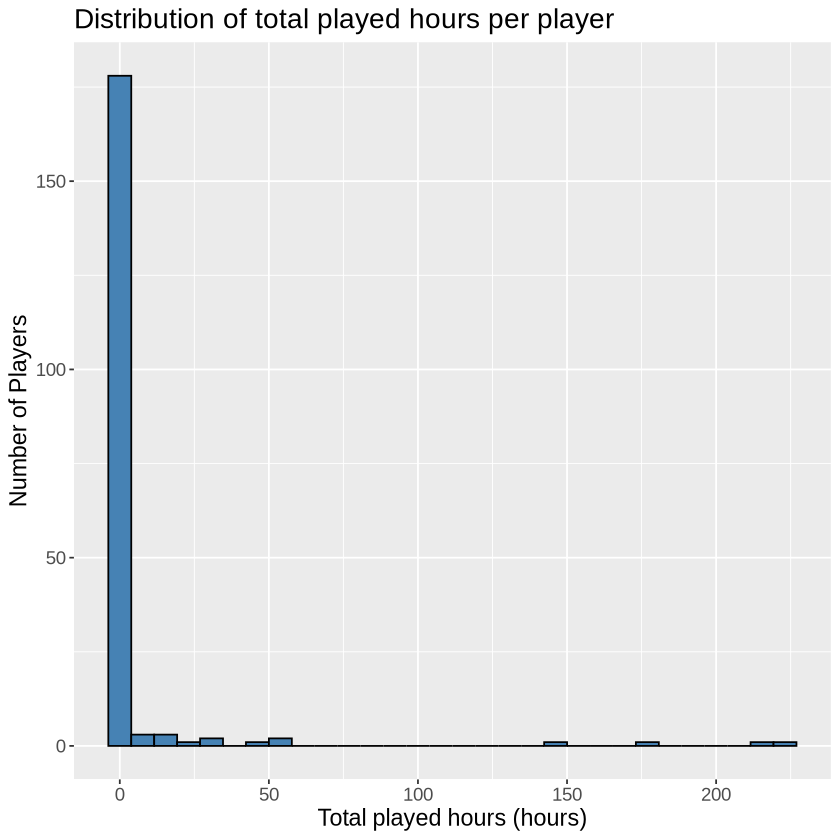

In [4]:
#Distribution of total hours played for each player
total_hours_dist_plot <- ggplot(tidy_players, aes(x = played_hours)) +
    geom_histogram(bins = 30, color = "black", fill = "steelblue") +
    labs(title = "Distribution of total played hours per player",
         x = "Total played hours (hours)",
         y = "Number of Players") +
    theme(text = element_text(size = 14))

total_hours_dist_plot

#INSIGHTS FROM VISUALISATION BELOW:
# played_hours is highly skewed to the right - there is a large disparity between the number of casual and regular players.
# This imbalance may require oversampling if modeling is going to be done on player features.

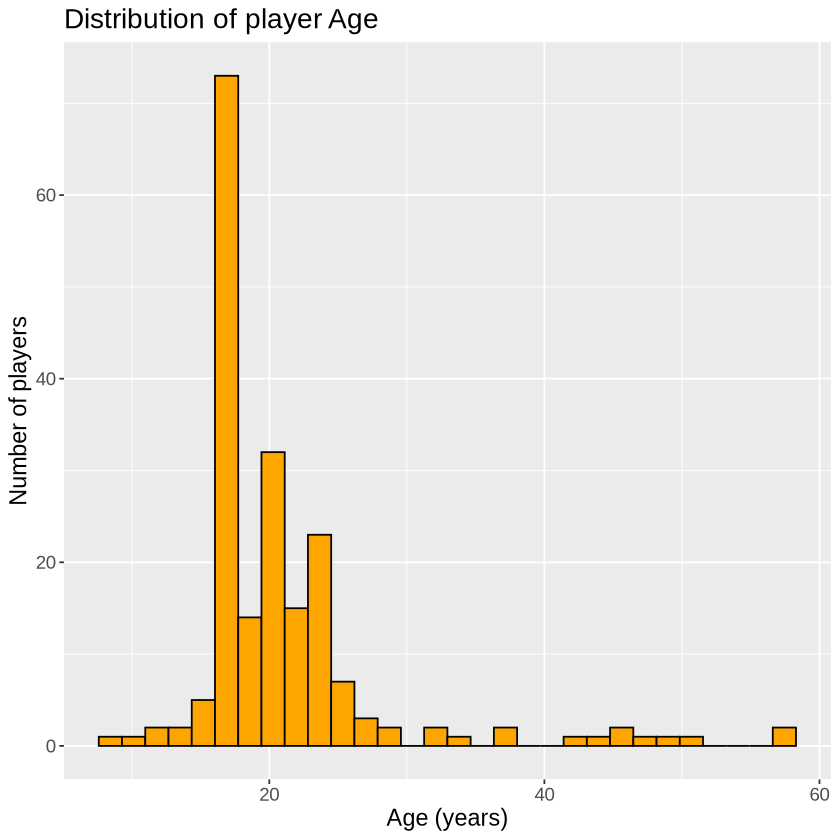

In [5]:
#Distribution of age 
age_dist_plot <- ggplot(tidy_players, aes(x = Age)) +
    geom_histogram(bins = 30, color = "black", fill = "orange") +
    labs(title = "Distribution of player Age",
         x = "Age (years)",
         y = "Number of players") +
    theme(text = element_text(size = 14))

age_dist_plot

#INSIGHTS FROM VISUALISATION BELOW:
# Distribution of age seems to be concentrated in the late teens/early twenties.
# This demographic composition may explain time of day patterns with highest traffic on server (students vs employed adults).

In [6]:
sessions <- read_csv("https://raw.githubusercontent.com/beam-9/dsci-100-2025w1-group-003-10/refs/heads/main/data/sessions.csv")
head(sessions)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [7]:
n_obs_sessions <- nrow(sessions)
n_vars_sessions <- ncol(sessions)

n_obs_sessions #num of observations
n_vars_sessions #num of variables

summary_email_sessions <- sessions |>
    group_by(hashedEmail) |>
    summarize(count = n()) |> #how often a player re entered and played the game 
    arrange(-count)

summary_email_sessions 

sessions <- sessions |>
  mutate(
      duration_ms = original_end_time - original_start_time,
      duration_min = round(duration_ms / 1000 / 60, 2))

# Compute summary statistics for session durations (in minutes)
session_duration_summary <- sessions |>
  summarise(
    count_sessions = n(),
    average_duration_min = round(mean(duration_min, na.rm = TRUE), 2),
    shortest_duration_min = round(min(duration_min, na.rm = TRUE), 2),
    longest_duration_min = round(max(duration_min, na.rm = TRUE), 2),
    median_duration_min = round(median(duration_min, na.rm = TRUE), 2))

session_duration_summary

tidy_sessions <- sessions |> #players.csv without the two observations with N/A values for end times, and remove sessions with negative durations
    filter(!is.na(end_time),
          end_time >= start_time)

[1] 1535

[1] 5

hashedEmail,count
<chr>,<int>
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,310
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,219
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,159
ad6390295640af1ed0e45ffc58a53b2d9074b0eea694b16210addd44d7c81f83,147
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,130
b622593d2ef8b337dc554acb307d04a88114f2bf453b18fb5d2c80052aeb2319,95
24d4892c2c3ce11d3e54c3bf31ee218901cac7a2f564911d67424c8fdf0874fe,79
e74c60a92c0100e7240be56d66969db85856152b048c639331a3595f901461ae,47
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,41


count_sessions,average_duration_min,shortest_duration_min,longest_duration_min,median_duration_min
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1535,48.49,0,333.33,0


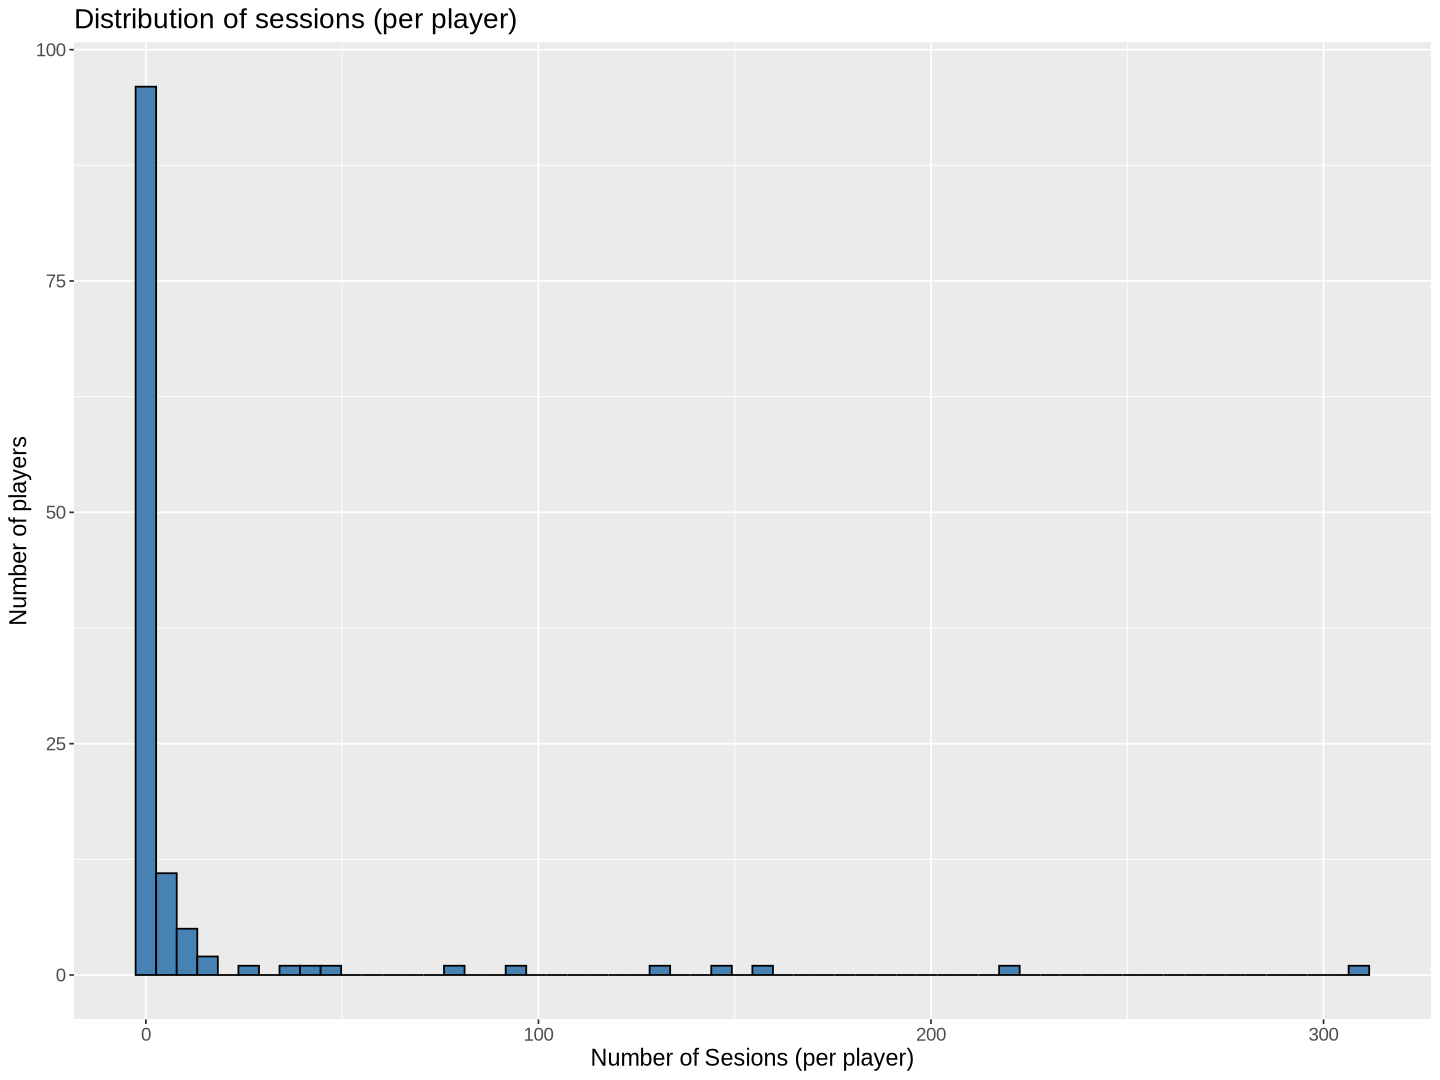

In [8]:
# Sessions per player
options(repr.plot.width = 12, repr.plot.height = 9)

sessions_per_player_dist <- ggplot(summary_email_sessions,
                                   aes(x = count)) +
                            geom_histogram(bins = 60, color = "black", fill = "steelblue") +
                            labs(title = "Distribution of sessions (per player)",
                                 x = "Number of Sesions (per player)",
                                 y = "Number of players") +
                            theme(text = element_text(size = 14))

sessions_per_player_dist

#INSIGHTS FROM VISUALISATION BELOW:
# Most players have <10 sessions with only a minority having more than this.
# This may cause a high variance when aggregating per-player contributions to the sessions due to uneven player engagement. 

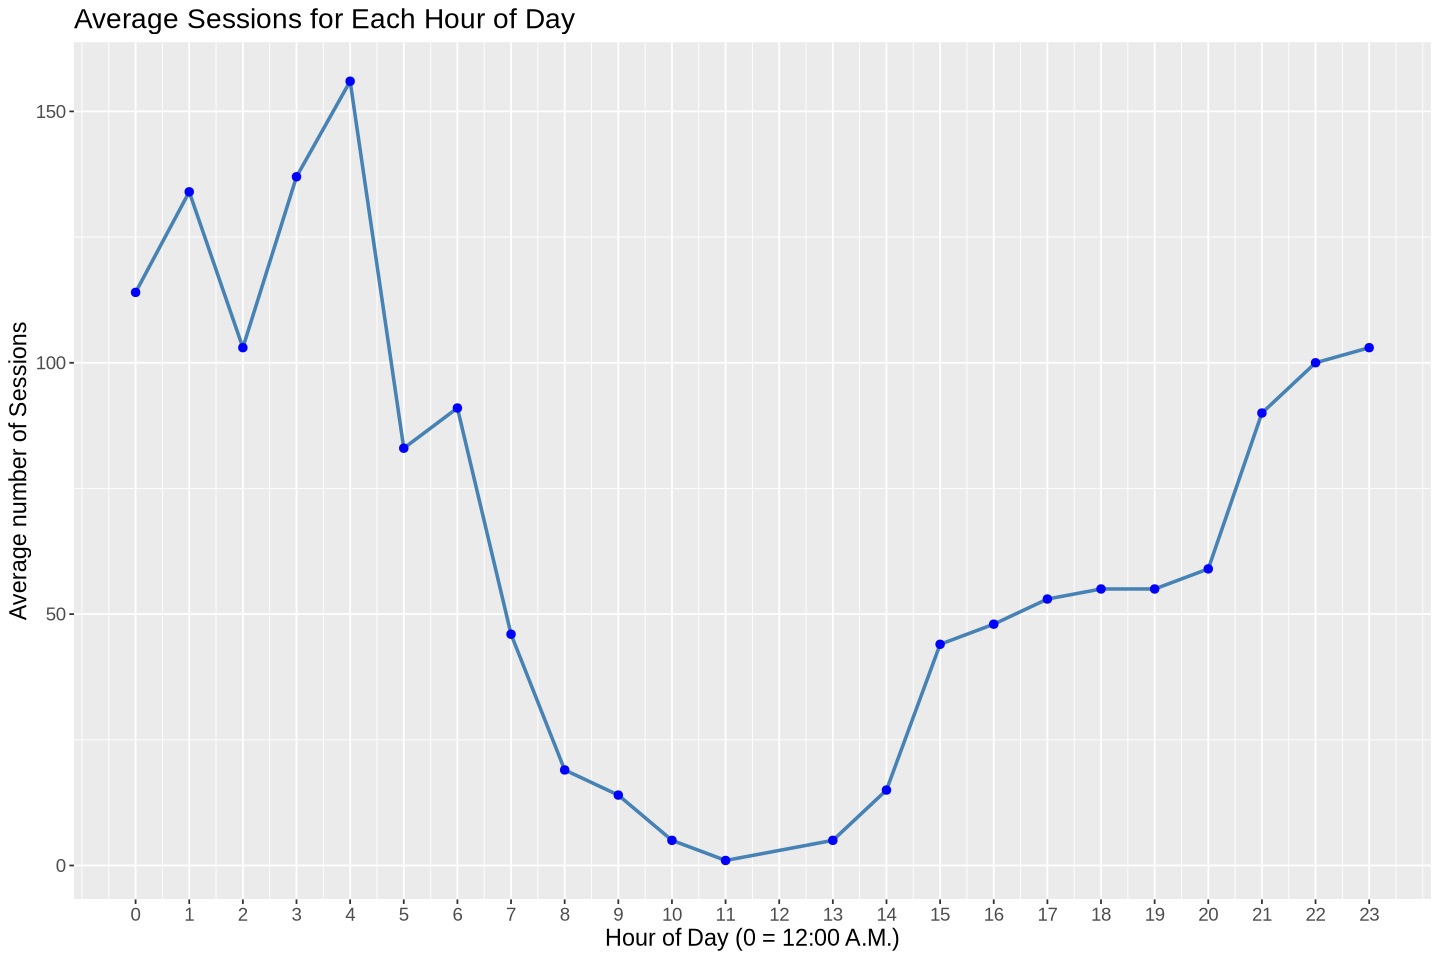

In [9]:
#Average sessions for each hour of day
options(repr.plot.width = 12, repr.plot.height = 8)

tidy_sessions <- tidy_sessions |>
    mutate(
        # Extract hour of day by converting the time to hours and dividing by 24, rounding down to get the hour started
        hour_of_day = floor((original_start_time / 1000 / 60 / 60) %% 24))

hourly_activity <- tidy_sessions |>
    group_by(hour_of_day) |>
    summarise(mean_sessions = n())

session_hour_plot <- hourly_activity |>
    ggplot(aes(x = hour_of_day, y = mean_sessions)) +
    geom_line(color = "steelblue", linewidth = 1) +
    geom_point(color = "blue", size = 2) +
    scale_x_continuous(breaks = 0:23) + #to represent each hour in the day
    labs(title = "Average Sessions for Each Hour of Day",
         x = "Hour of Day (0 = 12:00 A.M.)",
         y = "Average number of Sessions") +
    theme(text = element_text(size = 14))

session_hour_plot

#INSIGHTS FROM VISUALISATION BELOW:
# From the plot, we can see there is much lower activity during approximately 8 A.M. - 12 P.M. 
# However there is a sharp rise in traffic in the afternoon and evening hours, peaking around 4 A.M ~ (> 150 sessions active) before declining as morning arrives. 
# Such patterns can help predict high-load windows and inform when more licenses may be needed.

# Methods and Plan #

#### Method (Approach) ####
Multivariable linear regression (MLR) will model the relationship between the number of concurrent players and predictors including: player metrics and time-based features. This approach helps capture how factors: time of day, day of week, and recent activity trends influence server load.

#### Why this method is appropriate ####
Given the nature of the response variable being continuous, MLR is suitable for modeling mean relationships and provides interpretable coefficients for extrapolation and quantifies  each predictor's contribution to changes in server load.

#### Assumptions required ####
- Linearity is present between predictors and response variables.
- non-negative concurrent player counts.

#### Potential Limitations ####
- Ineffective in capturing non-linear trends or interactions.
- Outliers may distort accuracy of regression line produced.
- Multicollinearity may reduce reliability of coefficients.

#### Model Comparison + Selection ####
Models will be evaluated based on their RMSE on training data and the RMSPE on the test data. The model with the lowest RMSE will be selected after an iterative process of finding the best set of predictors in accurately predicting the number of concurrent players active per time window.


#### Data processing plan ####
1. Summarise averages for data features and encode features (day of week = 1-7).
2. Splitting data into training and testing subsets (80/20).
3. Fit regression models on the training set - evaluating performance for each.
4. Choose final model with the lowest RMSE.

In [68]:
# joining the two dataframes by hashedEmail
sessions_players_joined <- tidy_players |>
  left_join(tidy_sessions, by = "hashedEmail")


# remove empty strings and NAs from timestamps
clean_joined <- sessions_players_joined |>
  filter(!is.na(start_time),
         !is.na(end_time))


# extracting the hour that the session started, by taking the substring of start time
# up to where the hours stop.
clean_joined <- clean_joined |>
  mutate(hour_start = paste0(substr(start_time, 1, 13), ":00:00"))

# extracting only the hour
clean_joined <- clean_joined |>
  mutate(hour_of_day = as.numeric(substr(start_time, 12, 13)))

# extract weekday
#interpreting day of week - https://stackoverflow.com/questions/58528619/converting-dttm-to-date-formatting-with-as-date-and-as-date-give-different-r and https://www.youtube.com/watch?v=IXtkK4JDn28
clean_joined <- clean_joined |>
  mutate(date = substr(start_time, 1, 10),
         convert_date = as.Date(date),
         week_day  = weekdays(convert_date)) |>
  filter(!is.na(convert_date)) |>
  select(-date, -convert_date)



# Flagging experiences - https://www.youtube.com/watch?v=V2T488ogxBA
clean_joined <- clean_joined |>
  mutate(experience_flag = case_when(
         experience == "Pro" ~ 1,
         experience == "Experienced" ~ 1,
         experience == "Veteran" ~ 1,
         experience == "Expert" ~ 1,
         TRUE ~ 0))


final_df <- clean_joined |>
  group_by(hour_start) |>
  summarise(
    concurrent_players = n_distinct(hashedEmail),
    avg_played_hours   = mean(played_hours, na.rm = TRUE),
    avg_age            = mean(Age, na.rm = TRUE),
    avg_skill_level    = mean(experience_flag, na.rm = TRUE),
    hour_of_day,
    week_day
  )

final_df <- final_df |>
  mutate(week_day = as_factor(week_day)) |>
  mutate(week_day = fct_recode(week_day,  "1" = "Sunday" , "2" = "Monday", "3" = "Tuesday", "4" = "Wednesday", "5" = "Thursday", "6" = "Friday", "7" = "Saturday"))

final_df


Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'hour_start'. You can override using the
`.groups` argument.


hour_start,concurrent_players,avg_played_hours,avg_age,avg_skill_level,hour_of_day,week_day
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
01/05/2024 00:00:00,1,1.40000,25.0,1,0,1
01/05/2024 02:00:00,1,223.10000,17.0,0,2,1
01/05/2024 02:00:00,1,223.10000,17.0,0,2,1
01/05/2024 03:00:00,1,32.00000,22.0,0,3,1
01/05/2024 04:00:00,1,3.80000,17.0,1,4,1
01/05/2024 05:00:00,1,150.00000,16.0,0,5,1
01/05/2024 18:00:00,1,7.10000,17.0,0,18,1
01/05/2024 20:00:00,1,150.00000,16.0,0,20,1
01/05/2024 22:00:00,1,3.80000,17.0,1,22,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.07193686
rsq,standard,0.07649789
mae,standard,0.81346660


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.116495060,0.2174134067,9.7348875,1.296970e-21
avg_age,0.013933981,0.0092434572,1.5074426,1.319583e-01
avg_played_hours,-0.002312282,0.0004884992,-4.7334397,2.467793e-06
hour_of_day,-0.004979173,0.0036211785,-1.3750146,1.693815e-01
week_day4,-0.046734552,0.1160594640,-0.4026777,6.872565e-01
avg_skill_level,-0.071644273,0.1723065263,-0.4157955,6.776334e-01
week_day3,-0.079940597,0.1098457813,-0.7277530,4.669056e-01
week_day5,-0.299703476,0.1078611164,-2.7786054,5.543717e-03
week_day6,-0.303244607,0.1120984572,-2.7051631,6.922939e-03


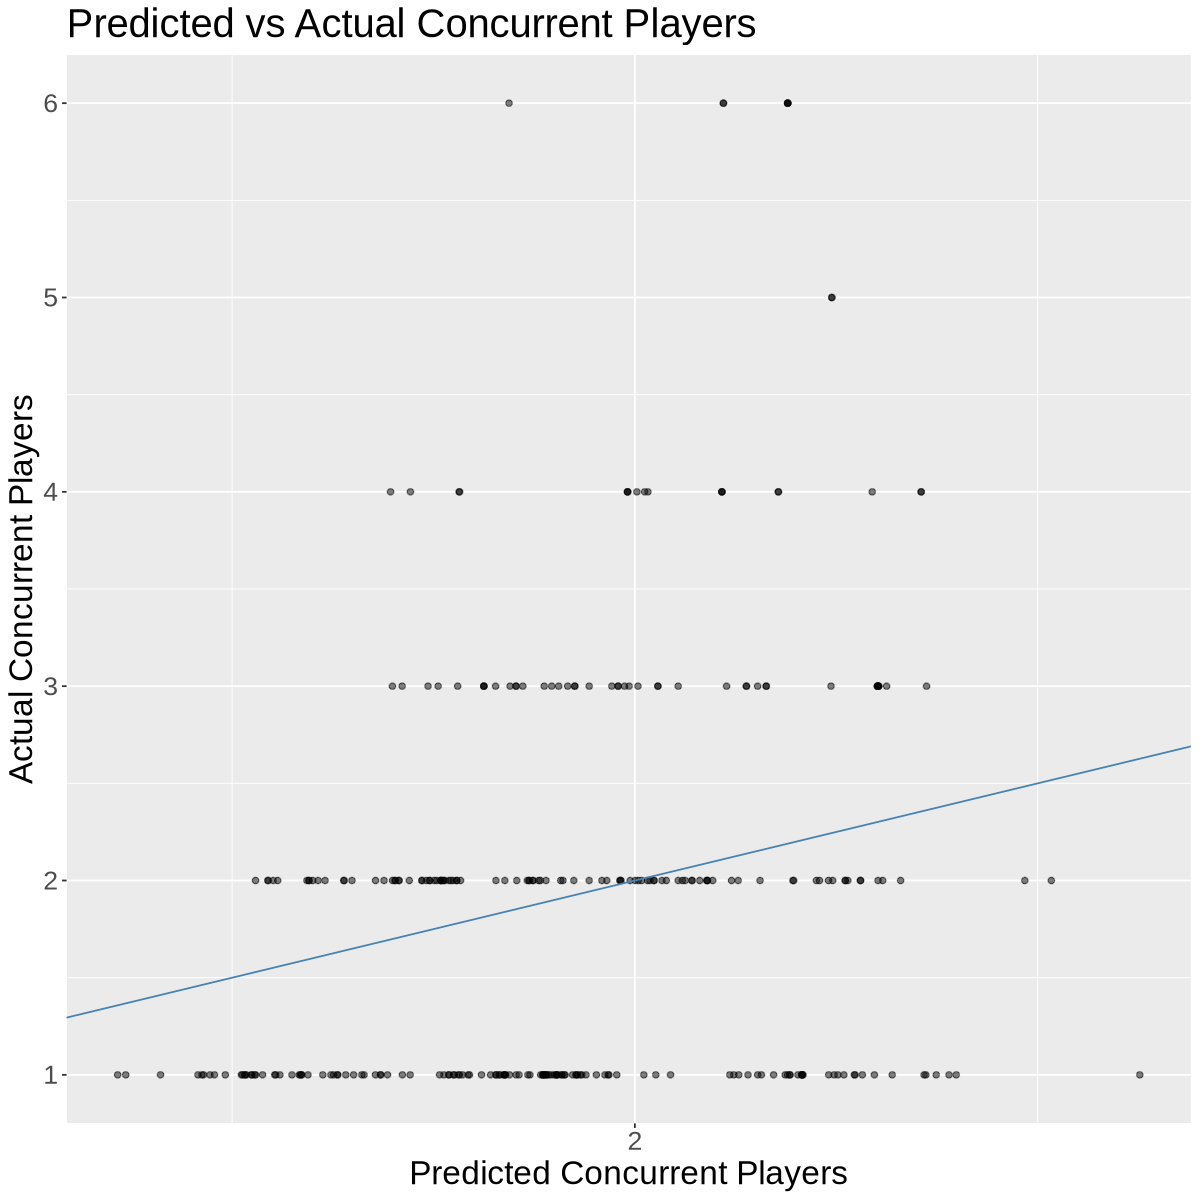

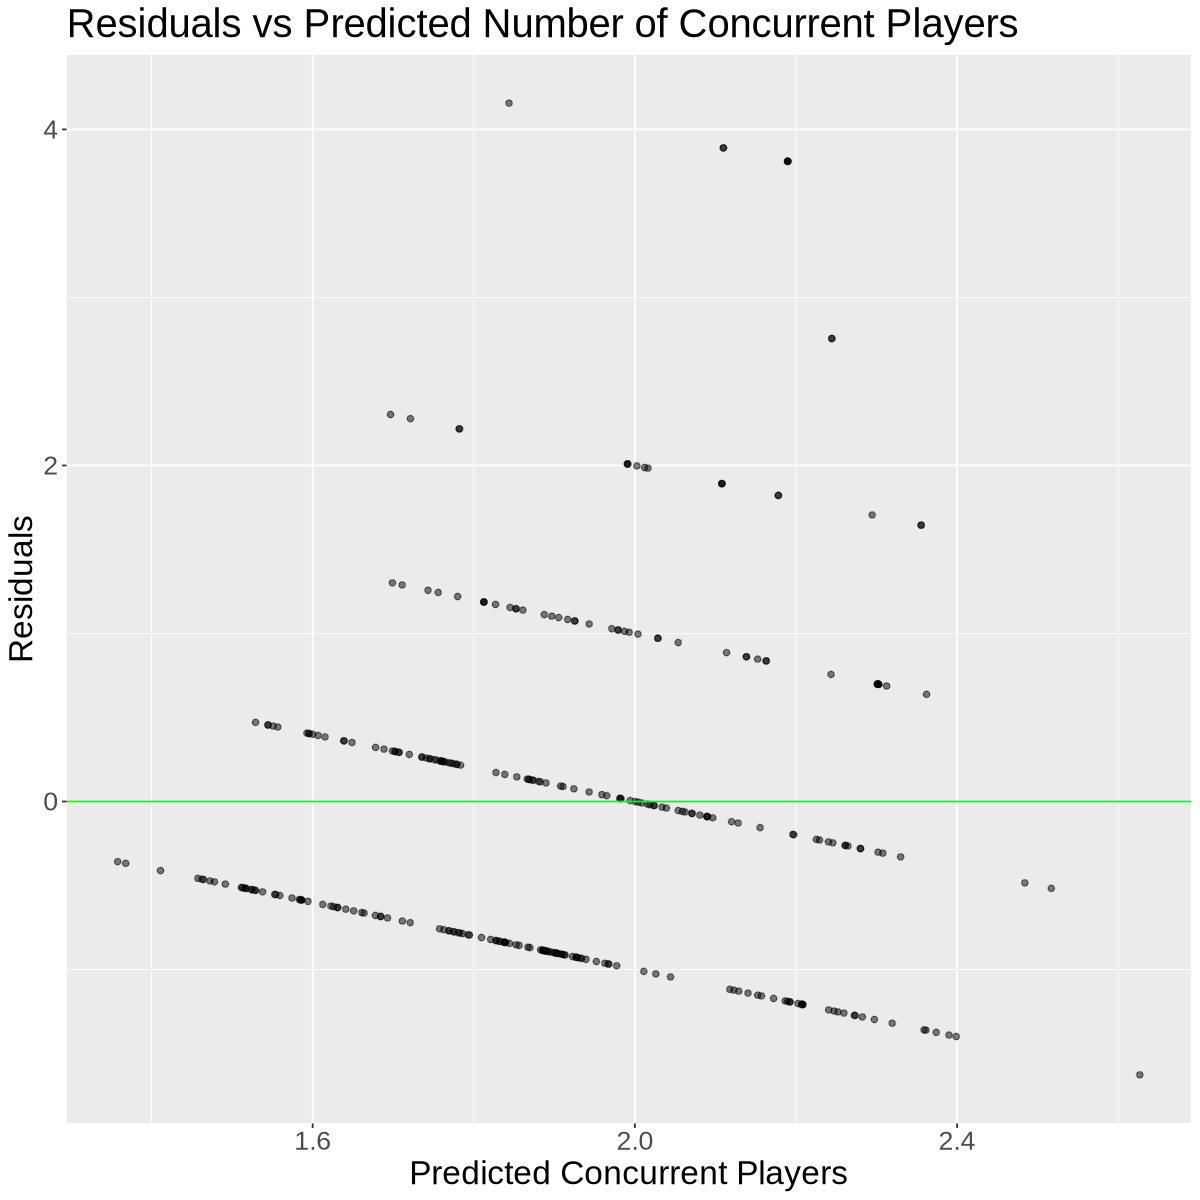

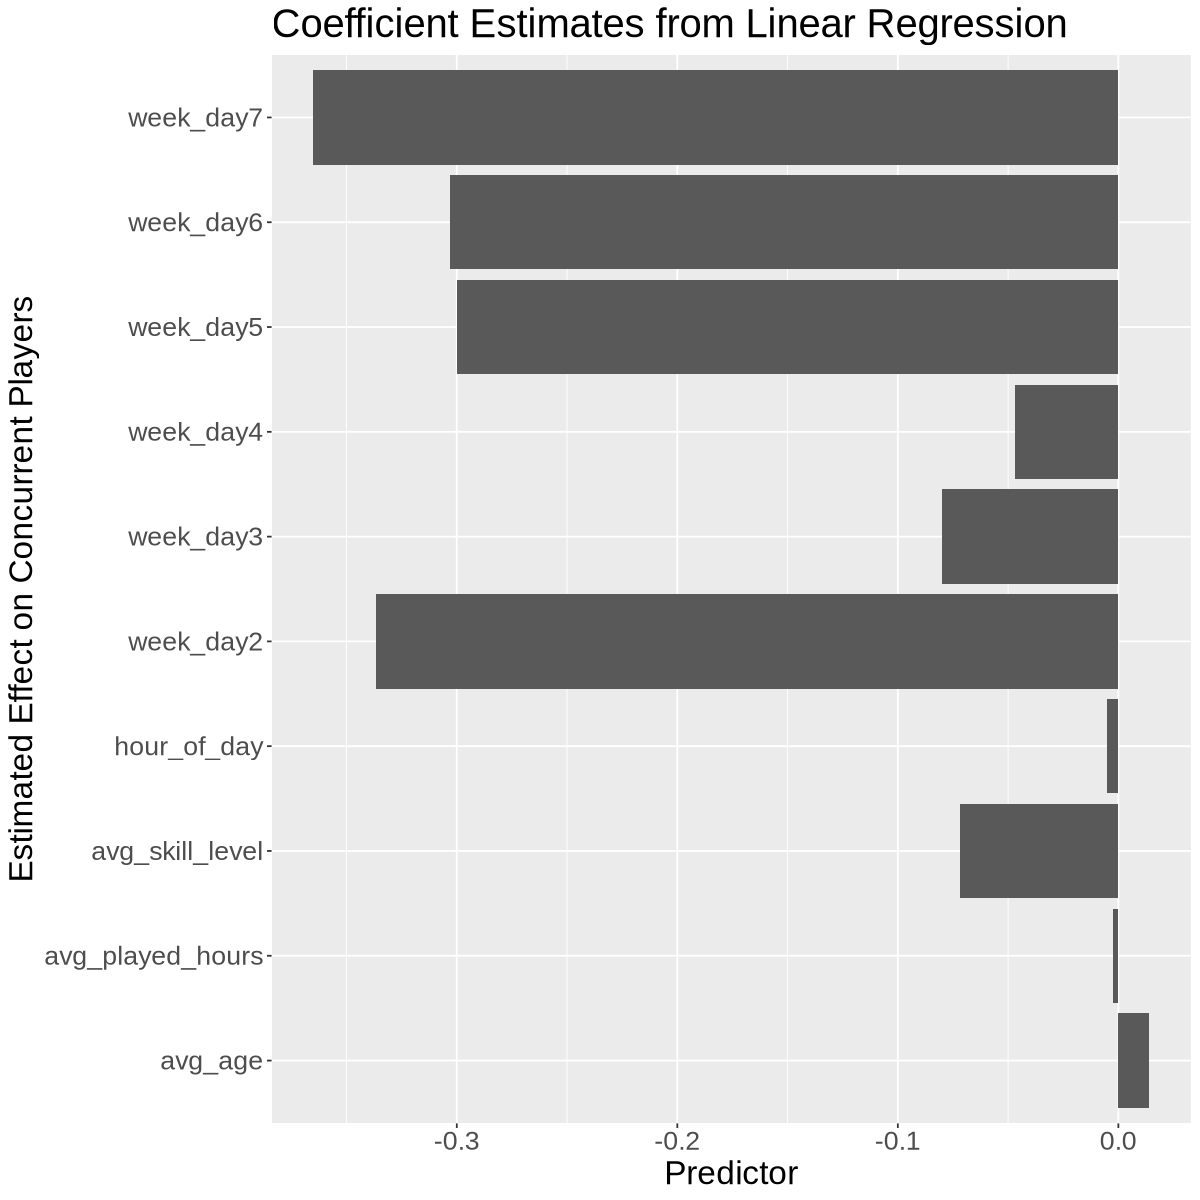

In [95]:
set.seed(123)

plaicraft_split <- initial_split(final_df, prop = 0.8, strata = concurrent_players)
plaicraft_train <- training(plaicraft_split)
plaicraft_test <- testing(plaicraft_split)

plaicraft_recipe <- recipe(concurrent_players ~ avg_played_hours + avg_age + avg_skill_level + hour_of_day + week_day, data = plaicraft_train)

plaicraft_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

plaicraft_fit <- workflow() |>
    add_recipe(plaicraft_recipe) |>
    add_model(plaicraft_spec) |>
    fit(data = plaicraft_train)

plaicraft_mult_results <- plaicraft_fit |>
  predict(plaicraft_test) |>
  bind_cols(plaicraft_test) 

plaicraft_mult_metrics <- plaicraft_mult_results |>
    metrics(truth = concurrent_players, estimate = .pred)

plaicraft_mult_metrics

coeffs <- plaicraft_fit |>
             extract_fit_parsnip() |>
             tidy() |>
             arrange(-estimate)

coeffs

options(repr.plot.width = 10, repr.plot.height = 10) 

prediction_plot <- plaicraft_mult_results |>
    ggplot(aes(x = .pred, y = concurrent_players)) +
    geom_point(alpha = 0.5) +
    geom_abline(intercept = 0, slope = 1, color = "steelblue") + #line of correct predicted number of concurrent players
    labs(title = "Predicted vs Actual Concurrent Players",
         x = "Predicted Concurrent Players",
         y = "Actual Concurrent Players") +
    theme(text = element_text(size = 20)) +
    scale_x_continuous(breaks = 0:6) +
    scale_y_continuous(breaks = 0:6)

prediction_plot



residual_df <- plaicraft_mult_results |>
    mutate(residual = concurrent_players - .pred)

residual_plot <- residual_df |>
    ggplot(aes(x = .pred, y = residual)) +
    geom_point(alpha = 0.5) +
    geom_hline(yintercept = 0, color = "green") +
    labs(title = "Residuals vs Predicted Number of Concurrent Players",
         x = "Predicted Concurrent Players",
         y = "Residuals") +
    theme(text = element_text(size = 20))

residual_plot


coeffs_plot_df <- coeffs |>
    filter(term != "(Intercept)")

coeffs_plot <- coeffs_plot_df |>
    ggplot(aes(x = estimate, y = term)) +
    geom_bar(stat = "identity") +
     labs(title = "Coefficient Estimates from Linear Regression",
         x = "Predictor",
         y = "Estimated Effect on Concurrent Players") +
    theme(text = element_text(size = 20))

coeffs_plot

    

week_day1 (Sunday) is not shown as its sued as the reference level. Sunday is the baseline so the coefficients for weekday show ow much lower or higher the number of concurrent players is compared to Sunday. Therefore if Sunday has the highest player activity, then all the other days would naturally have negative coefficients. The suggests that Sunday reprsents the peack acitivty period in the data set.

Average age having a slightly positive coefficient means hours in which the average of age of active players is higher tend to have slightly more concurrent players online.

Negative coefficient for hour of day indicates that later times of day are associated with slightly fewer concurretn players. But because the number of concurrent players in the dataset is generally low (mostly 1-2 players per hour) the modle coefficients are small in magnitutude and thus predominantly negative?